In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

pd.set_option('display.max_columns', 200)

In [22]:
DATA_DIR = Path('data')
TRAIN_PATH    = DATA_DIR / 'train.csv'
FEATURES_PATH = DATA_DIR / 'features.csv'
STORES_PATH   = DATA_DIR / 'stores.csv'

# Load what exists
frames = {}
for label, p in [('train', TRAIN_PATH), ('features', FEATURES_PATH), ('stores', STORES_PATH)]:
    if p.exists():
        frames[label] = pd.read_csv(p)
        print(f"Loaded {label}: {p} → {frames[label].shape}")
    else:
        print(f"Missing optional file: {p}")

# Choose base df
if 'train' in frames:
    df = frames['train'].copy()
else:
    raise FileNotFoundError('Could not find "train" file.')

df.head()

Loaded train: data/train.csv → (421570, 5)
Loaded features: data/features.csv → (8190, 12)
Loaded stores: data/stores.csv → (45, 3)


,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [9]:
# Standardize lower snake_case
orig_cols = {c: c for c in df.columns}
df.columns = [c.strip().lower() for c in df.columns]

# This detects/renames common variants if present
rename_map = {
    'weekly_sales':'weekly_sales',
    'weeklysales':'weekly_sales',
    'is_holiday':'isholiday',
    'is holiday':'isholiday',
    'holiday_flag':'isholiday',
}

df.rename(columns={k:v for k,v in rename_map.items() if k in df.columns}, inplace=True)

# Parse date
date_col = 'date' if 'date' in df.columns else None
if date_col:
    df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Ensure numeric types where expected
for col in ['weekly_sales', 'temperature', 'fuel_price', 'cpi', 'unemployment', 'size']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Ensure boolean holiday flag
if 'isholiday' in df.columns:
    # leave as int/bool; coerce text
    df['isholiday'] = df['isholiday'].astype(str).str.strip().str.lower().map({'true':1, 'false':0, '1':1, '0':0}).fillna(df['isholiday'])
    # try numeric conversion
    df['isholiday'] = pd.to_numeric(df['isholiday'], errors='coerce')

# Join with features, stores if available
if 'features' in frames:
    f = frames['features'].copy()
    f.columns = [c.strip().lower() for c in f.columns]
    f.rename(columns={k:v for k,v in rename_map.items() if k in f.columns}, inplace=True)
    if 'date' in f.columns:
        f['date'] = pd.to_datetime(f['date'], errors='coerce')
    join_keys = [k for k in ['store','date'] if k in df.columns and k in f.columns]
    if join_keys:
        df = df.merge(f, how='left', on=join_keys, suffixes=('', '_feat'))

if 'stores' in frames:
    s = frames['stores'].copy()
    s.columns = [c.strip().lower() for c in s.columns]
    join_keys = [k for k in ['store'] if k in df.columns and k in s.columns]
    if join_keys:
        df = df.merge(s, how='left', on=join_keys, suffixes=('', '_store'))

print('Unified shape:', df.shape)
df.head()

Unified shape: (421570, 29)


,store,dept,date,weekly_sales,isholiday,temperature,fuel_price,markdown1,markdown2,markdown3,markdown4,markdown5,cpi,unemployment,isholiday_feat,type,size,temperature_feat,fuel_price_feat,markdown1_feat,markdown2_feat,markdown3_feat,markdown4_feat,markdown5_feat,cpi_feat,unemployment_feat,isholiday_feat,type_store,size_store
0,1,1,2010-02-05,24924.50,0,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
1,1,1,2010-02-12,46039.49,1,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True,A,151315,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True,A,151315
2,1,1,2010-02-19,41595.55,0,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False,A,151315,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False,A,151315
3,1,1,2010-02-26,19403.54,0,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False,A,151315,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False,A,151315
4,1,1,2010-03-05,21827.90,0,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False,A,151315,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False,A,151315


In [11]:
print('\n--- dtypes ---')
print(df.dtypes)

print('\n--- sample ---')
display(df.head(10))

print('\n--- describe (numeric) ---')
df.select_dtypes(include=['number']).describe().T


--- dtypes ---
store                         int64
dept                          int64
date                 datetime64[ns]
weekly_sales                float64
isholiday                     int64
temperature                 float64
fuel_price                  float64
markdown1                   float64
markdown2                   float64
markdown3                   float64
markdown4                   float64
markdown5                   float64
cpi                         float64
unemployment                float64
isholiday_feat                 bool
type                         object
size                          int64
temperature_feat            float64
fuel_price_feat             float64
markdown1_feat              float64
markdown2_feat              float64
markdown3_feat              float64
markdown4_feat              float64
markdown5_feat              float64
cpi_feat                    float64
unemployment_feat           float64
isholiday_feat                 bool
type_store  

,store,dept,date,weekly_sales,isholiday,temperature,fuel_price,markdown1,markdown2,markdown3,markdown4,markdown5,cpi,unemployment,isholiday_feat,type,size,temperature_feat,fuel_price_feat,markdown1_feat,markdown2_feat,markdown3_feat,markdown4_feat,markdown5_feat,cpi_feat,unemployment_feat,isholiday_feat,type_store,size_store
0,1,1,2010-02-05,24924.50,0,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
1,1,1,2010-02-12,46039.49,1,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True,A,151315,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True,A,151315
2,1,1,2010-02-19,41595.55,0,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False,A,151315,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False,A,151315
3,1,1,2010-02-26,19403.54,0,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False,A,151315,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False,A,151315
4,1,1,2010-03-05,21827.90,0,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False,A,151315,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False,A,151315
5,1,1,2010-03-12,21043.39,0,57.79,2.667,NaN,NaN,NaN,NaN,NaN,211.380643,8.106,False,A,151315,57.79,2.667,NaN,NaN,NaN,NaN,NaN,211.380643,8.106,False,A,151315
6,1,1,2010-03-19,22136.64,0,54.58,2.720,NaN,NaN,NaN,NaN,NaN,211.215635,8.106,False,A,151315,54.58,2.720,NaN,NaN,NaN,NaN,NaN,211.215635,8.106,False,A,151315
7,1,1,2010-03-26,26229.21,0,51.45,2.732,NaN,NaN,NaN,NaN,NaN,211.018042,8.106,False,A,151315,51.45,2.732,NaN,NaN,NaN,NaN,NaN,211.018042,8.106,False,A,151315
8,1,1,2010-04-02,57258.43,0,62.27,2.719,NaN,NaN,NaN,NaN,NaN,210.820450,7.808,False,A,151315,62.27,2.719,NaN,NaN,NaN,NaN,NaN,210.820450,7.808,False,A,151315
9,1,1,2010-04-09,42960.91,0,65.86,2.770,NaN,NaN,NaN,NaN,NaN,210.622857,7.808,False,A,151315,65.86,2.770,NaN,NaN,NaN,NaN,NaN,210.622857,7.808,False,A,151315



--- describe (numeric) ---


,count,mean,std,min,25%,50%,75%,max
store,421570.0,22.200546,12.785297,1.000,11.000000,22.00000,33.000000,45.000000
dept,421570.0,44.260317,30.492054,1.000,18.000000,37.00000,74.000000,99.000000
weekly_sales,421570.0,15981.258123,22711.183519,-4988.940,2079.650000,7612.03000,20205.852500,693099.360000
isholiday,421570.0,0.070358,0.255750,0.000,0.000000,0.00000,0.000000,1.000000
temperature,421570.0,60.090059,18.447931,-2.060,46.680000,62.09000,74.280000,100.140000
fuel_price,421570.0,3.361027,0.458515,2.472,2.933000,3.45200,3.738000,4.468000
markdown1,150681.0,7246.420196,8291.221345,0.270,2240.270000,5347.45000,9210.900000,88646.760000
markdown2,111248.0,3334.628621,9475.357325,-265.760,41.600000,192.00000,1926.940000,104519.540000
markdown3,137091.0,1439.421384,9623.078290,-29.100,5.080000,24.60000,103.990000,141630.610000
markdown4,134967.0,3383.168256,6292.384031,0.220,504.220000,1481.31000,3595.040000,67474.850000


In [12]:
# Unique counts per column (helps spot categoricals)
unique_counts = df.nunique(dropna=False).sort_values(ascending=False)
unique_counts

,0
weekly_sales,359464
temperature,3528
temperature_feat,3528
markdown5_feat,2294
markdown5,2294
markdown1,2278
markdown1_feat,2278
cpi_feat,2145
cpi,2145
markdown4,1945


In [13]:
missing = df.isna().sum().sort_values(ascending=False)
missing_pct = (missing/len(df)).round(4)
missing_report = pd.DataFrame({'missing': missing, 'missing_pct': missing_pct})
missing_report[missing_report['missing']>0]

,missing,missing_pct
markdown2,310322,0.7361
markdown2_feat,310322,0.7361
markdown4,286603,0.6798
markdown4_feat,286603,0.6798
markdown3,284479,0.6748
markdown3_feat,284479,0.6748
markdown1_feat,270889,0.6426
markdown1,270889,0.6426
markdown5_feat,270138,0.6408
markdown5,270138,0.6408


In [14]:
dups = df.duplicated().sum()
print('Duplicate rows:', dups)

Duplicate rows: 0


In [15]:
# Copy for cleaning
clean = df.copy()

# Derive time parts if date exists
if 'date' in clean.columns:
    clean['year'] = clean['date'].dt.year
    clean['month'] = clean['date'].dt.month
    clean['weekofyear'] = clean['date'].dt.isocalendar().week.astype(int)

# Imputation utilities
from collections import defaultdict
impute_report = defaultdict(dict)

# Numeric columns (except target) → median
num_cols = clean.select_dtypes(include=[np.number]).columns.tolist()
if 'weekly_sales' in num_cols:
    num_cols.remove('weekly_sales')

for col in num_cols:
    if clean[col].isna().any():
        val = clean[col].median()
        clean[col].fillna(val, inplace=True)
        impute_report[col]['strategy'] = 'median'
        impute_report[col]['value'] = float(val) if pd.notna(val) else None

# Categorical columns → mode
cat_cols = clean.select_dtypes(include=['object','category']).columns.tolist()
for col in cat_cols:
    if clean[col].isna().any():
        mode_val = clean[col].mode(dropna=True)
        mode_val = mode_val.iloc[0] if not mode_val.empty else 'Unknown'
        clean[col].fillna(mode_val, inplace=True)
        impute_report[col]['strategy'] = 'mode'
        impute_report[col]['value'] = str(mode_val)

# For target weekly_sales: drop rows with NaN target
if 'weekly_sales' in clean.columns:
    before = len(clean)
    clean = clean.dropna(subset=['weekly_sales'])
    print(f"Dropped {before-len(clean)} rows due to NaN weekly_sales (target)")

print('Clean shape:', clean.shape)

Dropped 0 rows due to NaN weekly_sales (target)
Clean shape: (421570, 32)


/tmp/ipython-input-4125479766.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  clean[col].fillna(val, inplace=True)


In [16]:
def iqr_outlier_mask(s, k=1.5):
    q1, q3 = s.quantile(0.25), s.quantile(0.75)
    iqr = q3 - q1
    lower, upper = q1 - k*iqr, q3 + k*iqr
    return (s < lower) | (s > upper)

report = {}
for col in ['weekly_sales','temperature','fuel_price','cpi','unemployment','size']:
    if col in clean.columns:
        m = iqr_outlier_mask(clean[col].dropna())
        report[col] = round(float(m.mean()*100),2)

pd.Series(report, name='% Outliers by IQR').sort_values(ascending=False)

,% Outliers by IQR
weekly_sales,8.43
unemployment,7.62
temperature,0.02
fuel_price,0.00
cpi,0.00
size,0.00


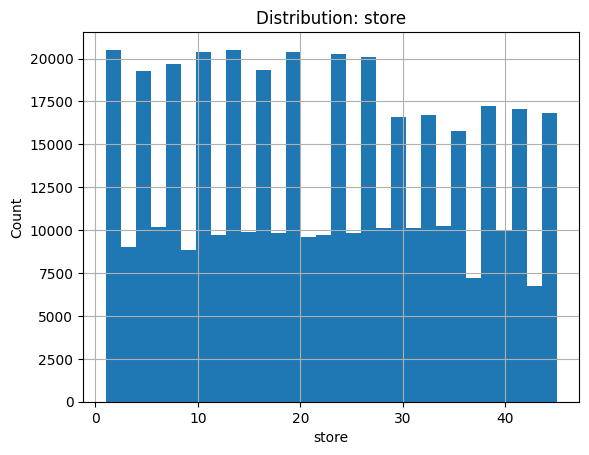

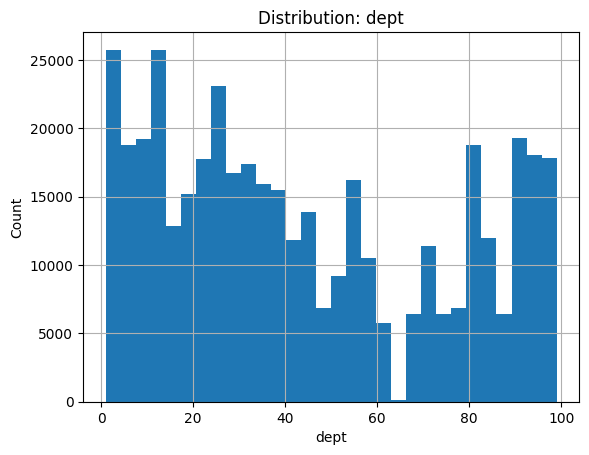

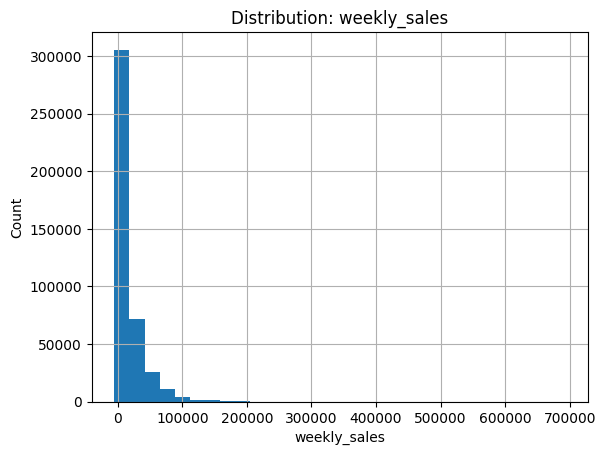

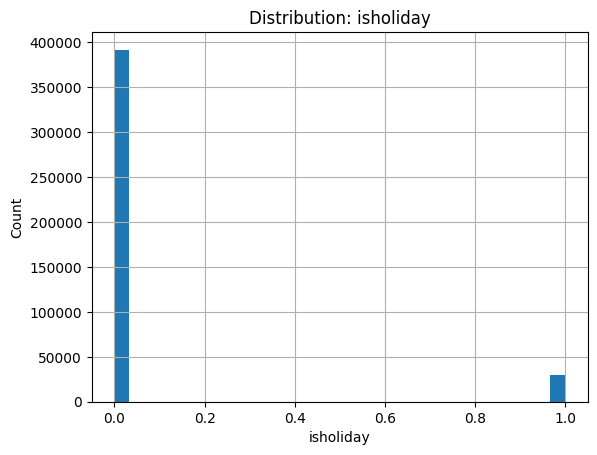

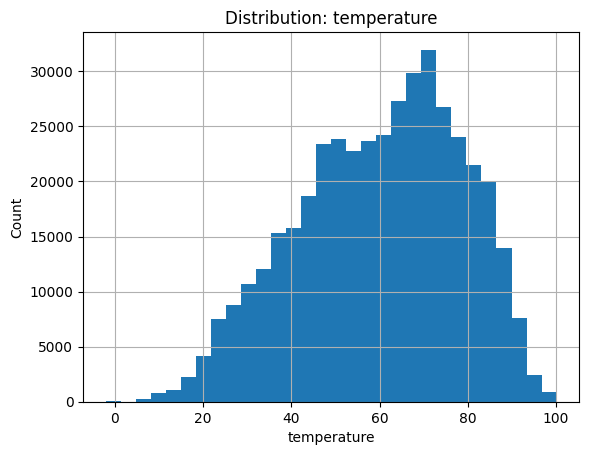

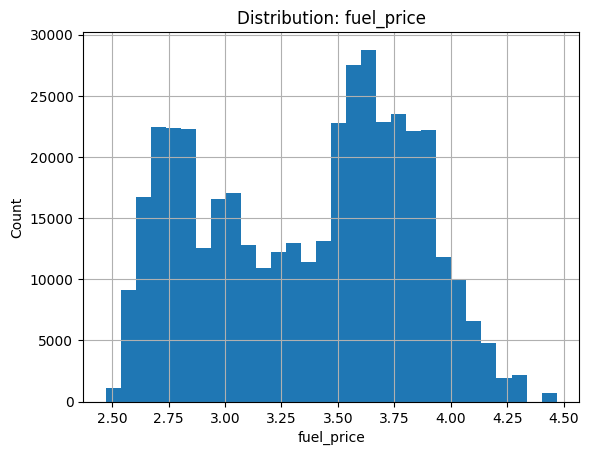

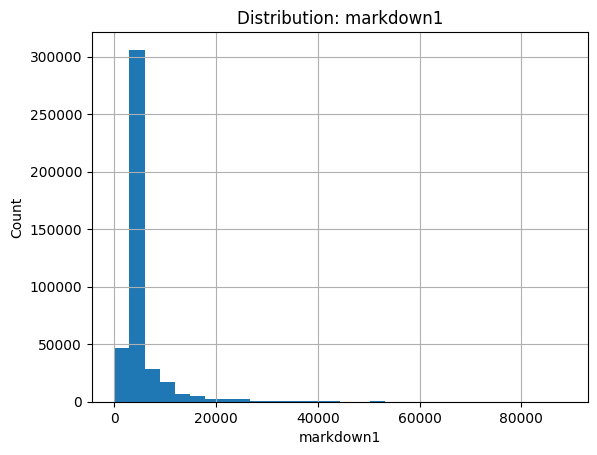

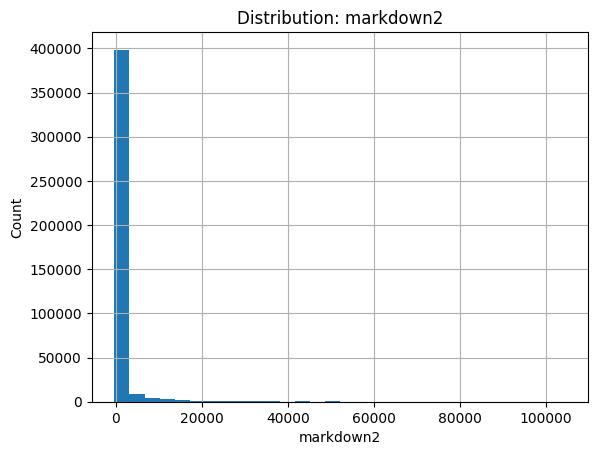

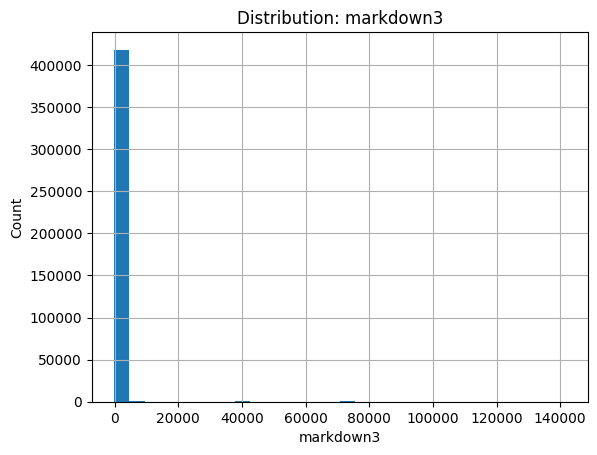

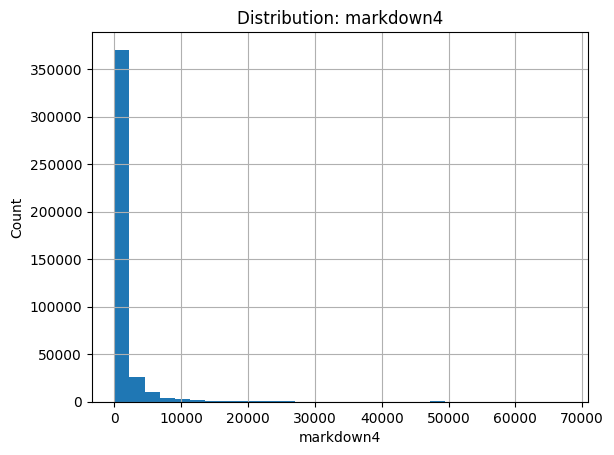

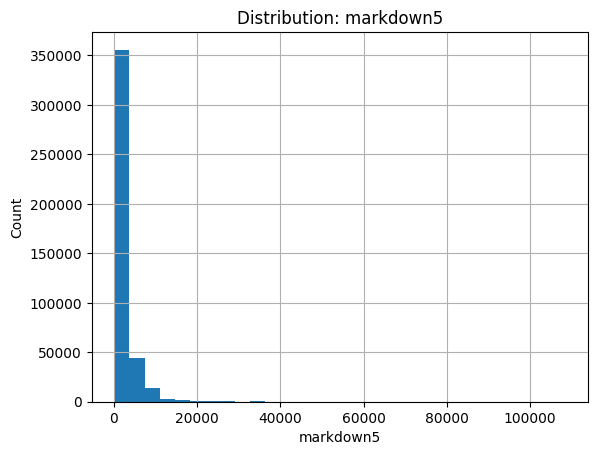

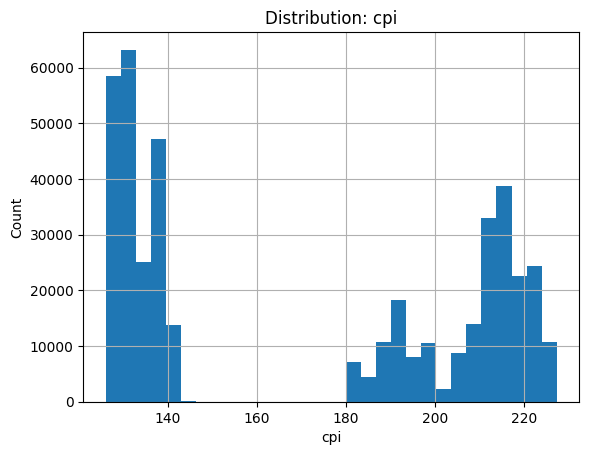

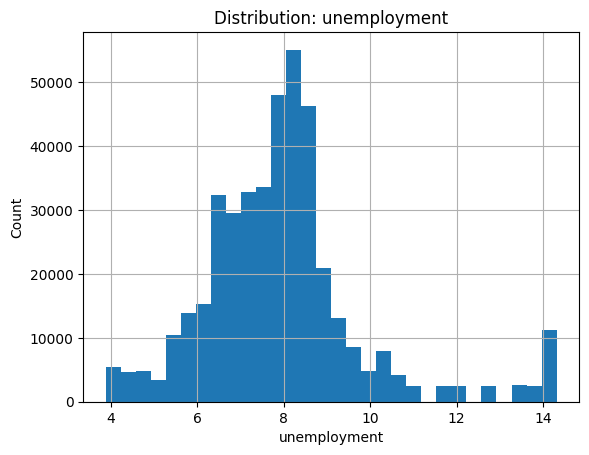

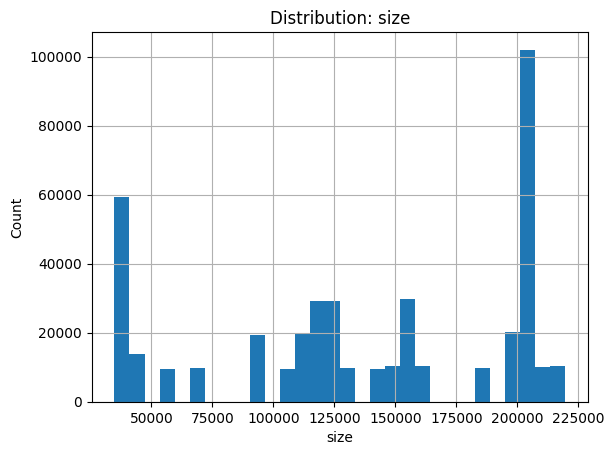

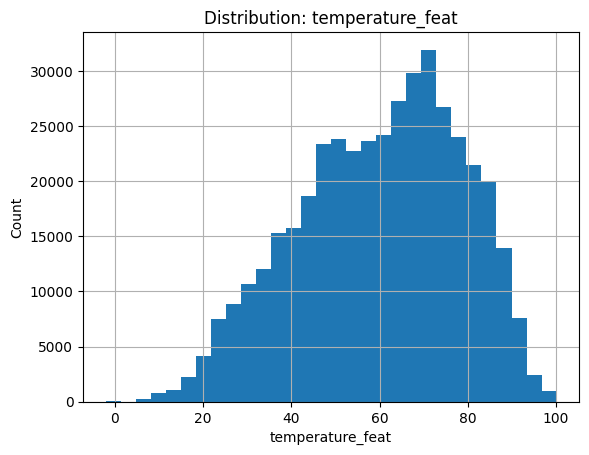

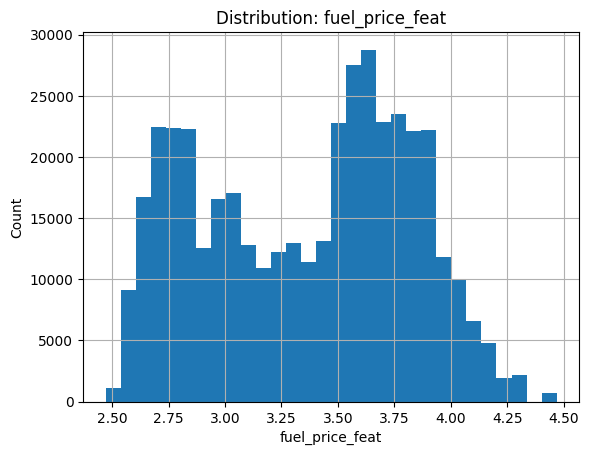

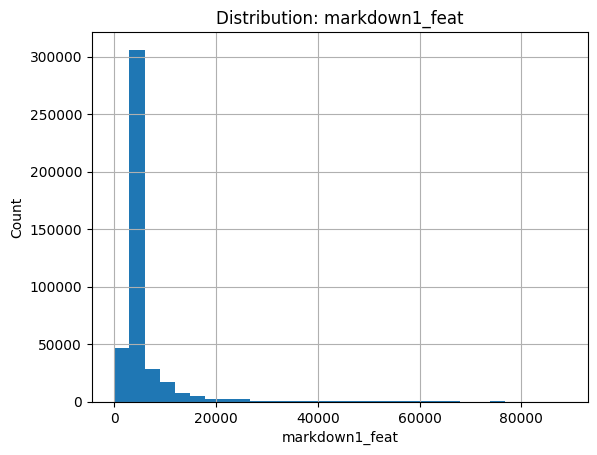

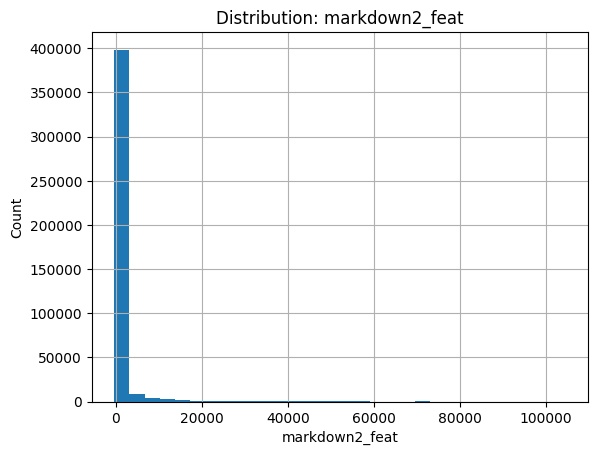

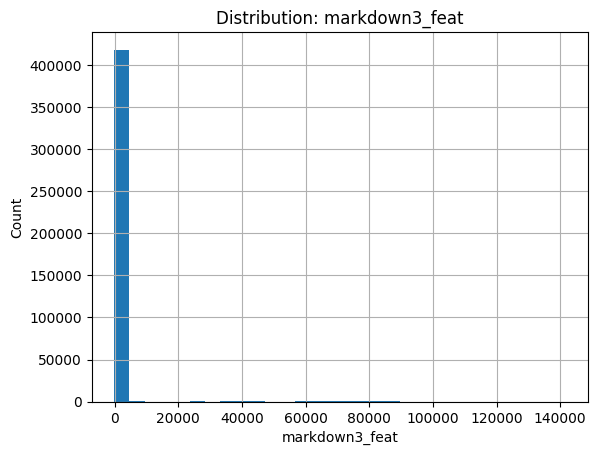

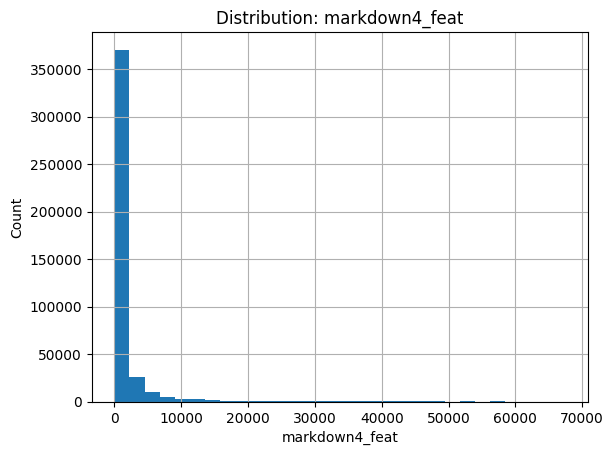

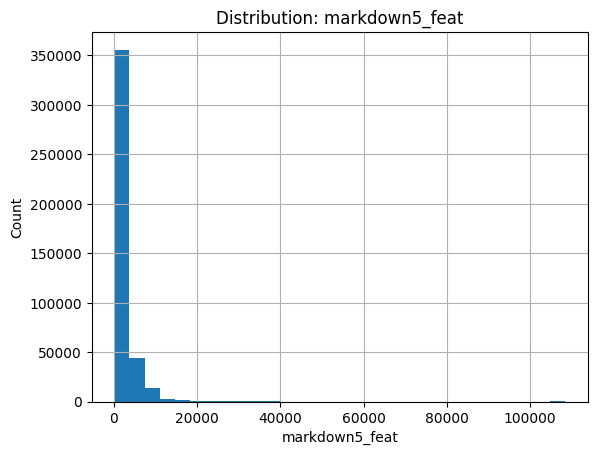

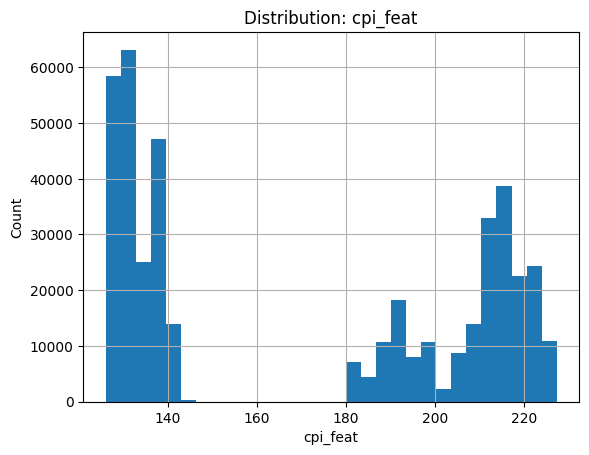

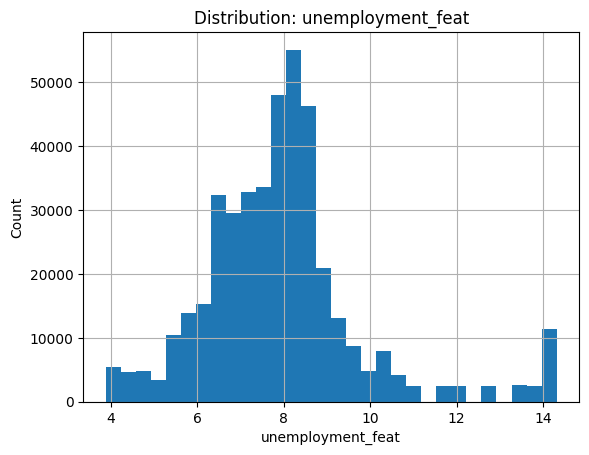

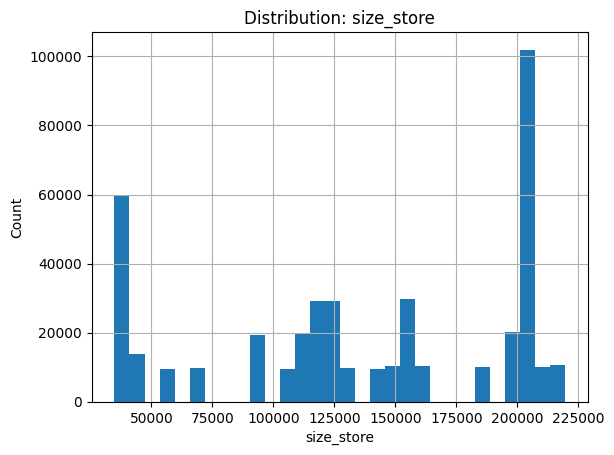

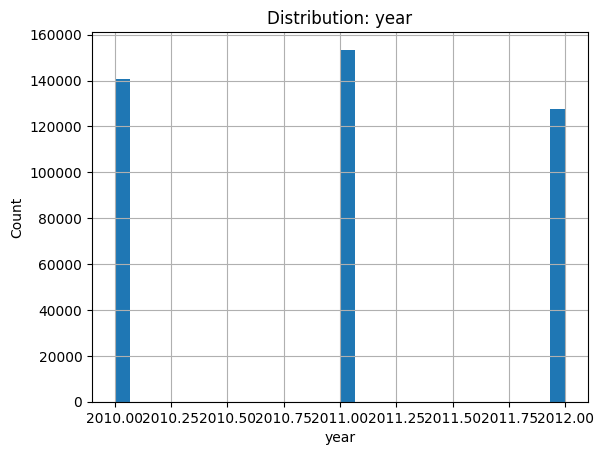

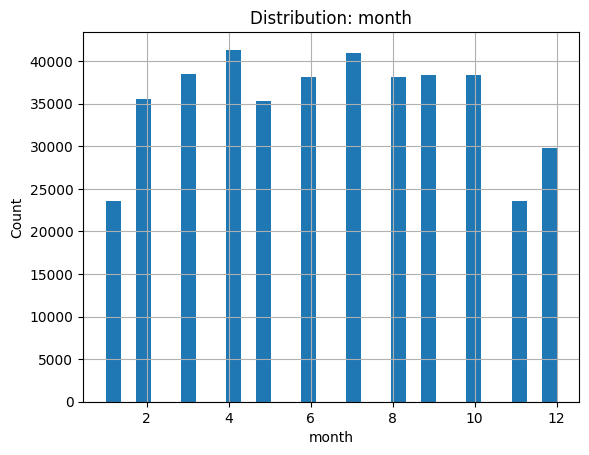

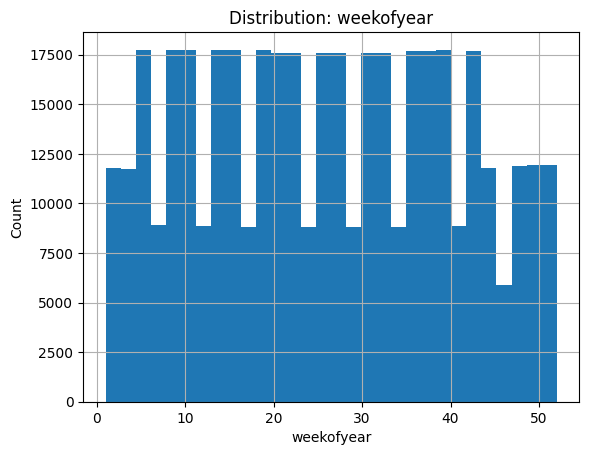

In [17]:
# Histograms
num_cols_all = clean.select_dtypes(include=[np.number]).columns
for col in num_cols_all:
    plt.figure()
    clean[col].hist(bins=30)
    plt.title(f'Distribution: {col}')
    plt.xlabel(col); plt.ylabel('Count')
    plt.show()

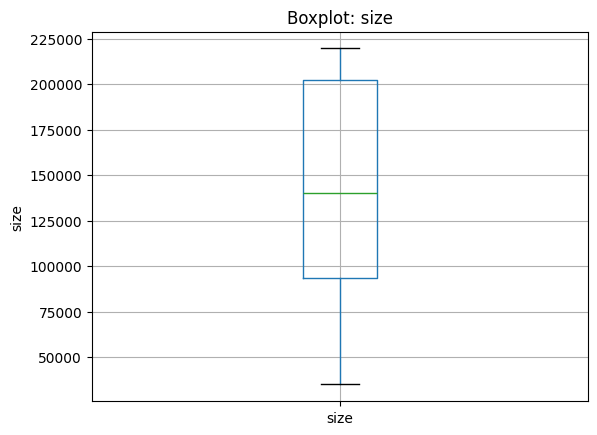

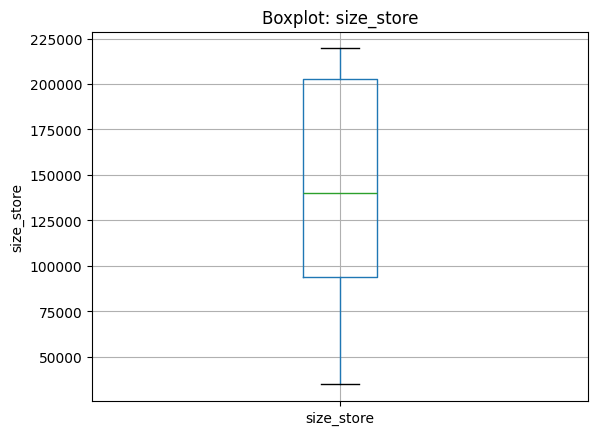

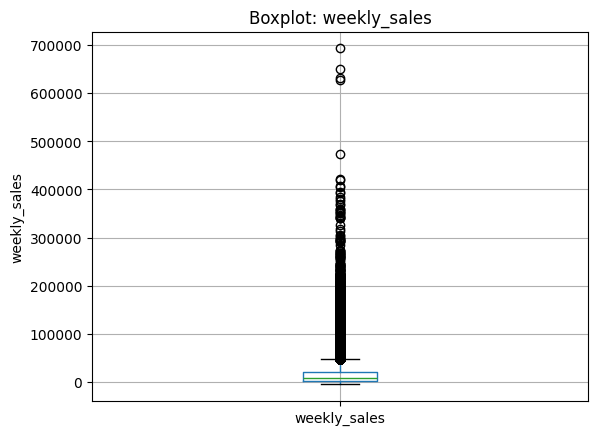

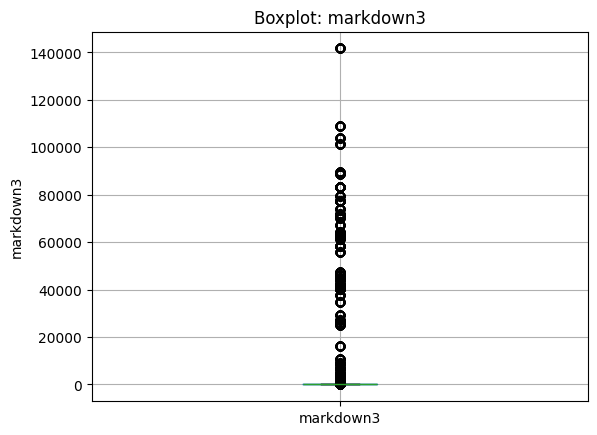

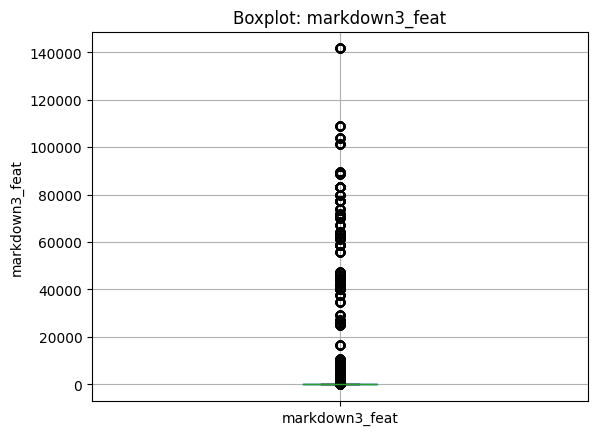

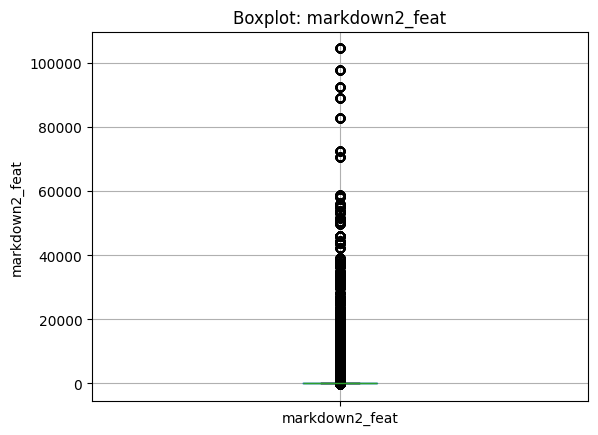

In [18]:
# Boxplots (top-variance numerics)
variances = clean[num_cols_all].var().sort_values(ascending=False)
for col in variances.head(min(6, len(variances))).index:
    plt.figure()
    clean.boxplot(column=col)
    plt.title(f'Boxplot: {col}')
    plt.ylabel(col)
    plt.show()

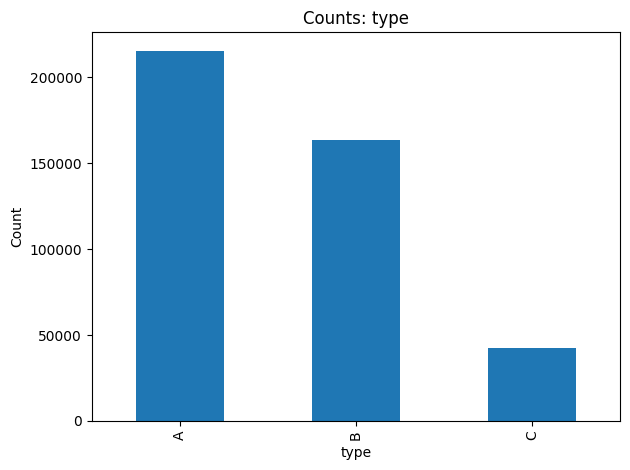

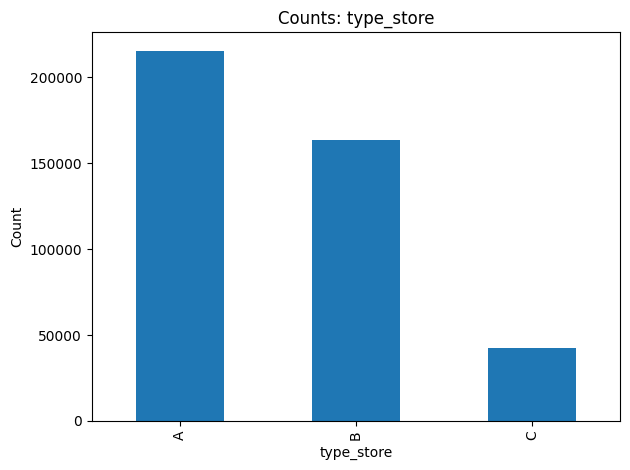

In [19]:
# Categorical bars (top 5 columns by unique size)
cat_cols_all = clean.select_dtypes(include=['object','category']).columns
for col in cat_cols_all[:5]:
    counts = clean[col].value_counts(dropna=False).head(15)
    plt.figure()
    counts.plot(kind='bar')
    plt.title(f'Counts: {col}')
    plt.xlabel(col); plt.ylabel('Count')
    plt.tight_layout(); plt.show()

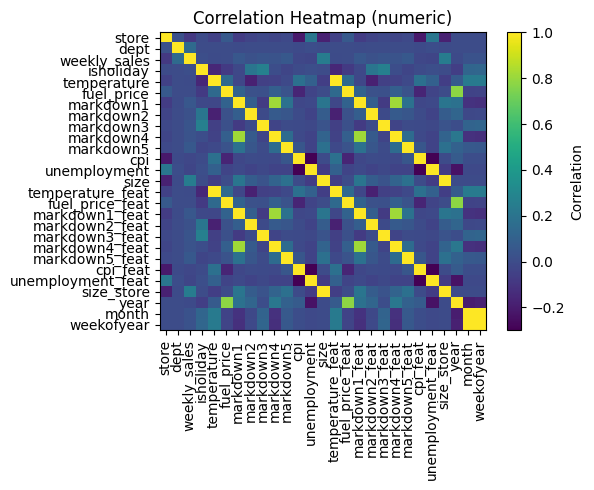

In [20]:
# Correlation heatmap (numeric)
num_cols_heat = clean.select_dtypes(include=[np.number]).columns
if len(num_cols_heat)>1:
    corr = clean[num_cols_heat].corr(numeric_only=True)
    plt.figure(figsize=(6,5))
    plt.imshow(corr, aspect='auto', interpolation='nearest')
    plt.title('Correlation Heatmap (numeric)')
    plt.colorbar(label='Correlation')
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.index)), corr.index)
    plt.tight_layout(); plt.show()

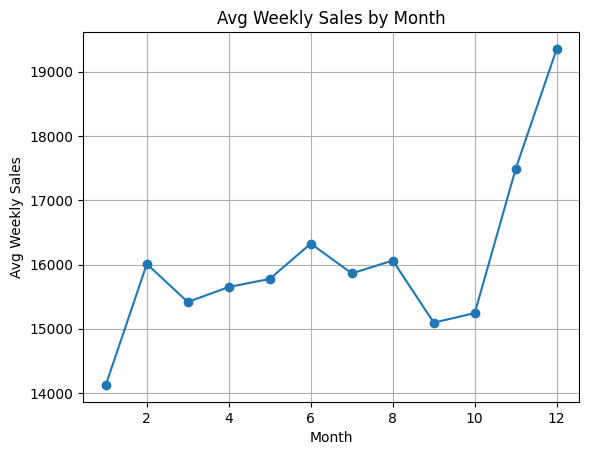

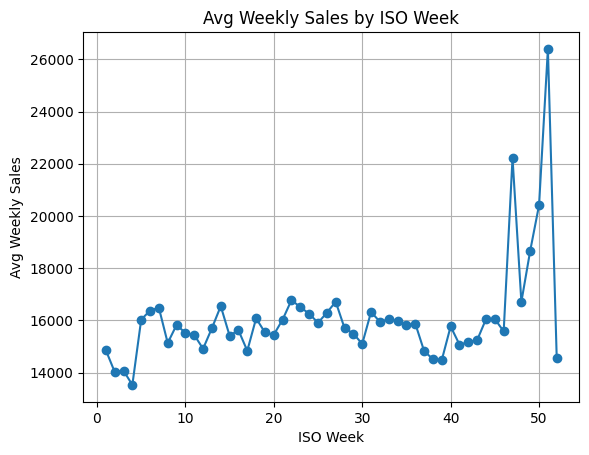

In [21]:
# Seasonality plots
if 'date' in clean.columns and 'weekly_sales' in clean.columns:
    by_month = clean.groupby('month')['weekly_sales'].mean().sort_index() if 'month' in clean.columns else None
    by_week  = clean.groupby('weekofyear')['weekly_sales'].mean().sort_index() if 'weekofyear' in clean.columns else None
    if by_month is not None:
        plt.figure(); by_month.plot(kind='line', marker='o'); plt.title('Avg Weekly Sales by Month'); plt.xlabel('Month'); plt.ylabel('Avg Weekly Sales'); plt.grid(True); plt.show()
    if by_week is not None:
        plt.figure(); by_week.plot(kind='line', marker='o'); plt.title('Avg Weekly Sales by ISO Week'); plt.xlabel('ISO Week'); plt.ylabel('Avg Weekly Sales'); plt.grid(True); plt.show()